# Optimization of KPP demonstration

In this notebook we demonstrate the optimization of KPP.

We consider a case with wind-driven shear mixing and neutral buoyancy forcing.

In [1]:
using Pkg; Pkg.activate("..")

using PyPlot, Printf
using OceanTurb, Dao, ColumnModelOptimizationProject, ColumnModelOptimizationProject.KPPOptimization

datadir = joinpath("..", "data", "idealized")
cases = ["free_convection", "shear_neutral", "shear_unstable", "shear_stable"]
dirs = Dict((c, joinpath(datadir, c)) for c in cases)

examples = Dict(
    "free_convection" => "wind_stress_N256_tau0_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_neutral"   => "wind_stress_N256_tau0.1_Q0_dTdz0.001_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_unstable"  => "wind_stress_N256_tau0.1_Q-75_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2",
    "shear_stable"    => "wind_stress_N256_tau0.04_Q10_dTdz0.01_k0.0001_dt0.25_days6_timeseries.jld2" 
)

examplepaths = Dict((c, joinpath(dirs[c], examples[c])) for c in cases)

┌ Info: Recompiling stale cache file /Users/gregorywagner/.julia/compiled/v1.1/Dao/pfxnO.ji for Dao [923aee56-57d8-11e9-2f0d-e3e88a113be6]
└ @ Base loading.jl:1184


Dict{String,String} with 4 entries:
  "shear_unstable"  => "../data/idealized/shear_unstable/wind_stress_N256_tau0.…
  "shear_stable"    => "../data/idealized/shear_stable/wind_stress_N256_tau0.04…
  "free_convection" => "../data/idealized/free_convection/wind_stress_N256_tau0…
  "shear_neutral"   => "../data/idealized/shear_neutral/wind_stress_N256_tau0.1…

# The model and the data

First we instantiate our column data and our column model.

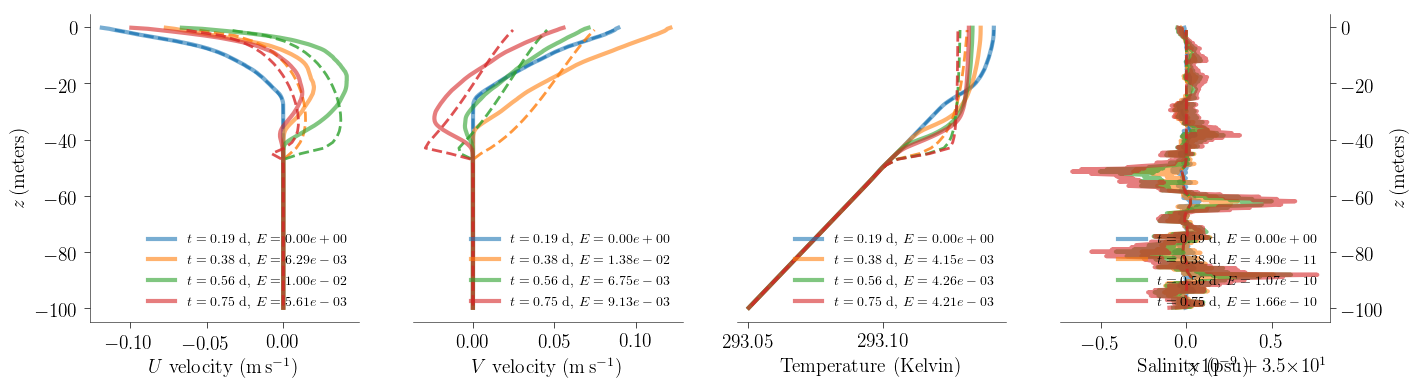

(Figure(PyObject <Figure size 1600x400 with 4 Axes>), PyCall.PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x141eaeac8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1421c06a0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1421e7c18>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x1422171d0>])

In [13]:
column_data = ColumnData(examplepaths["shear_neutral"]; targets=(3, 4, 5))
column_model = KPPOptimization.ColumnModel(column_data, 10*minute, N=50)
default_params = DefaultFreeParameters(ShearNeutralParameters)

fig, axs = visualize_realization(default_params, column_model, column_data)

# The 'Negative Log Likelihood' function

Next we define a simple function to compute the negative log likelihood, as well as a
`sampler` that uses the Metropolis algorithm with normally distributed random perturbations
for proposal parameter vectors.

In [14]:
defaults = DefaultFreeParameters(ShearNeutralParameters)
nll = NegativeLogLikelihood(column_model, column_data, temperature_cost)
first_link = MarkovLink(nll, defaults)

MarkovLink{Float64,ShearNeutralParameters{Float64}}([0.1, 0.3, 0.4], 0.004206602303810792)

# Initializing the Markov Chain

We show here how to fiddle with parameters associated with the Metropolis algorithm to obtain a good acceptance ratio and Markov chain.

In [38]:
@show nll.scale = first_link.error * 0.5

std = ShearNeutralParameters(
    CSL = 0.05*defaults.CSL, 
    CRi = 0.5*defaults.CRi, 
     Cτ = 0.5*defaults.Cτ
)
sampler = MetropolisSampler(NonNegativeNormalPerturbation(std));

@time chain = MarkovChain(10^2, first_link, nll, sampler)
@show chain.acceptance

nll.scale = first_link.error * 0.5 = 0.002103301151905396
  1.135279 seconds (25.68 M allocations: 394.562 MiB, 2.57% gc time)
chain.acceptance = 0.12121212121212122


0.12121212121212122

# Extending the Markov Chain

Next we extend the Markov Chain and plot results

In [ ]:
@time extend!(chain, 10^4)

errs = errors(chain)
optimal_param, optimal_error = optimal(chain)

@show chain.acceptance chain.links[1].param optimal_param chain.links[1].error optimal_error

fig, axs = visualize_realization(optimal_param, column_model, column_data)
fig.suptitle("Optimal solution")

fig, axs = visualize_realization(chain.links[1].param, column_model, column_data)
fig.suptitle("Initial solution")